# 📊 コンペティション概要：TOPIX200 銘柄リターン予測コンペ

コンペの目的:
TOPIXの上位200銘柄の日次リターンデータ（daily_return_20200101_20241031.csv）を用いて、2024年11月の日次リターンを予測し、ポートフォリオを構築して月次リターンの最大化を目指します。


---


## 🛑 データ利用に関する重要な注意事項

このコンペティションで配布されるデータ（例：
`daily_return_20200101_20241031.csv`、など）は、**学内受講者に限定して提供される非公開データ**です。

### ❗以下の点を厳守してください：

* データの**再配布、公開、外部への共有は禁止**します。
* 講義・課題の目的に限って利用を許可します。
* コンペ終了後はデータを破棄すること。

> この条件に同意した受講者のみが、チュートリアルの内容およびデータを使用できます。

---


### 📅 スケジュール

| 日付       | 内容                |
| -------- | ----------------- |
| 6月13日（金） | コンペのアナウンス    　　   |
| 7月4日（木）  | 質問・相談会（講義なし）      |
| 7月11日（木） | 質問・相談会（講義なし）      |
| 7月21日（月） | 提出締切（23:59 JST厳守） |
| 7月25日（金） | ランキング発表・講評        |

- ❗7月4日・11日の講義では出席を取りません。希望者のみ自由参加で質問・相談を受け付けます。

---

## 📈 コンペルール

### ✅ タスク

* **目的**：2024年11月の日次リターン（推測対象）を各銘柄ごとに予測
* **目標**：予測したリターンに基づき、**構成比率10％以内**の制約のもとでポートフォリオを構築し、**月次リターンを最大化**

### 🔢 制約条件

* 各銘柄の**構成比率は最大10%**
* 全銘柄の構成比率の合計は**100%になるように正規化**

---

## 🗃️ 提出物（すべて必要）

### 1. 📄 **予測モデルのコード**

* Pythonを用いること
* 再現可能であること（必要なライブラリ明記）

### 2. 📊 **ポートフォリオ構成比（CSV形式）**

* ファイル名：`portfolio_学籍番号.csv`
* 構成例（2024年11月予測ベース）：

| Stock No. | Weight |
| ------ | ------ |
| 1   | 0.10   |
| 2   | 0.08   |
| ???   | ????   |
| 200 | 0.01   |

* Weightの合計は1.0、各銘柄は0.1以下とすること

### 3. 🖼️ **解説スライド（PDF, 最大3ページ）**

* 以下の内容を含む：

  * 予測モデルの概要（特徴量やアルゴリズムの選定理由）
  * 構成比率の算出方法
  * 成果と考察

---

## 🧪 評価方法

* **評価指標：2024年11月のポートフォリオの月次リターン**

  * 非公開の2024年11月実データを用いて算出
  * 各銘柄の予測があたっていても、構成比の設計が悪いとリターンが上がらない可能性あり

---

## 💡備考

* 使用するファイル：`daily_return_20200101_20241031.csv`（準備済み）
* 予測対象の「2024年11月」データは主催者側が採点用に保有
* 授業はありませんが、7/4、7/11の時間に**コードの質問、考え方の相談**等を受け付けます。
* Signate主催のSMBCコンペの参加でも評価します。お好きなほうにご参加ください。

---



## Library and Data Input

In [ ]:
import datetime
import statsmodels.api as sm
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras import layers,Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Dense, Flatten, Reshape,Dropout, BatchNormalization, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell
from tensorflow.keras.layers import SimpleRNN
tf.random.set_seed(42)
np.random.seed(42)
print(tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

from tqdm import tqdm_notebook
from itertools import product
from typing import Union
import importlib.util
import sys
# japanize-matplotlib が未インストールなら pip install
if importlib.util.find_spec("japanize_matplotlib") is None:
  !pip install japanize-matplotlib
# 必要なライブラリのインポート
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

2.18.0
GPU Available: []


In [ ]:
# データのロード from GitHubのrawデータURL
u1 = "https://raw.githubusercontent.com/CS-Advanced/DATA/main/daily_return_20200101_20241031.csv"
u2 = "https://raw.githubusercontent.com/CS-Advanced/DATA/main/portfolio_sample.csv"
# リターンデータの読み込み
train = pd.read_csv(u1, index_col=0, parse_dates=True)
#200銘柄等ウェイトのポートフォリオ
portfolio_equal_weight = pd.read_csv(u2)

In [ ]:
train.head()

,stock_001,stock_002,stock_003,stock_004,stock_005,stock_006,stock_007,stock_008,stock_009,stock_010,...,stock_191,stock_192,stock_193,stock_194,stock_195,stock_196,stock_197,stock_198,stock_199,stock_200
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-07,0.040917,0.018158,0.022354,0.017541,-0.010890,0.002230,0.006719,0.031669,0.004293,0.013701,...,0.028075,0.011740,0.024389,0.015709,0.017600,0.021217,0.026366,0.008819,0.016629,0.019489
2020-01-08,-0.026071,-0.006559,-0.020463,-0.014779,0.000166,-0.026930,-0.009592,0.000785,0.001590,-0.017674,...,0.007502,-0.020085,-0.021521,-0.015415,-0.011232,-0.021631,-0.027737,-0.006354,-0.006527,-0.017698
2020-01-09,0.022992,0.008001,0.007526,-0.009926,0.048506,0.020611,0.051315,0.018835,-0.026886,0.018175,...,0.039775,0.008835,0.021551,0.006097,0.010322,0.001863,0.016197,0.019436,0.036406,0.012923
2020-01-10,0.001519,0.005579,0.004950,-0.011607,0.012762,0.002269,0.014404,0.005081,-0.002137,0.001430,...,0.008156,0.002388,0.015718,-0.006750,0.008443,-0.004847,0.006942,-0.001118,0.011159,0.001475
2020-01-14,-0.003585,0.015481,-0.000913,0.001174,-0.022870,0.000011,0.018501,0.024617,-0.019518,0.001110,...,0.010971,0.005519,-0.009171,-0.004313,0.026032,0.008007,-0.000046,0.017396,-0.003147,-0.009317


In [ ]:
portfolio_equal_weight.head()

,Stock No.,Weight
0,stock_001,0.005
1,stock_002,0.005
2,stock_003,0.005
3,stock_004,0.005
4,stock_005,0.005


In [ ]:
# 2024年11月は20日営業日
# 最後の20営業日をテストセットに、残りを訓練セットに分割
test_size = 20
train_df = train.iloc[:-test_size]
test_df = train.iloc[-test_size:]

In [ ]:
# 訓練期間の平均月次リターン（57ヶ月）
mean_monthly_return = (1 + train_df).prod() ** (1 / 57) - 1
mean_monthly_return.name = "Train"

# テスト期間の平均月次リターン（1ヶ月＝20日）
test_return = (1 + test_df).prod() - 1
test_return.name = "Test"

# DataFrameを縦に結合
return_df = pd.concat([mean_monthly_return, test_return], axis=1).reset_index()
return_df = return_df.rename(columns={"index": "Stock No."})
return_df.head()

,Stock No.,Train,Test
0,stock_001,0.008760,-0.012183
1,stock_002,0.003616,-0.052316
2,stock_003,0.004628,-0.060361
3,stock_004,0.003214,0.003817
4,stock_005,-0.001558,-0.000067


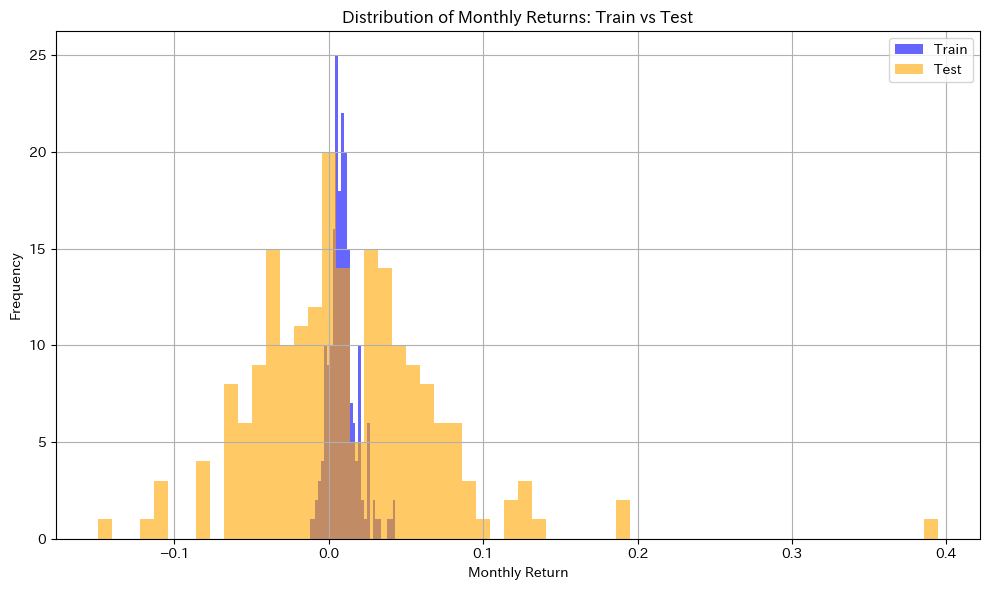

In [ ]:
# ヒストグラムの描画
plt.figure(figsize=(10, 6))
plt.hist(return_df["Train"], bins=30, alpha=0.6, label="Train", color='blue')
plt.hist(return_df["Test"], bins=60, alpha=0.6, label="Test", color='orange')
plt.xlabel("Monthly Return")
plt.ylabel("Frequency")
plt.title("Distribution of Monthly Returns: Train vs Test")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

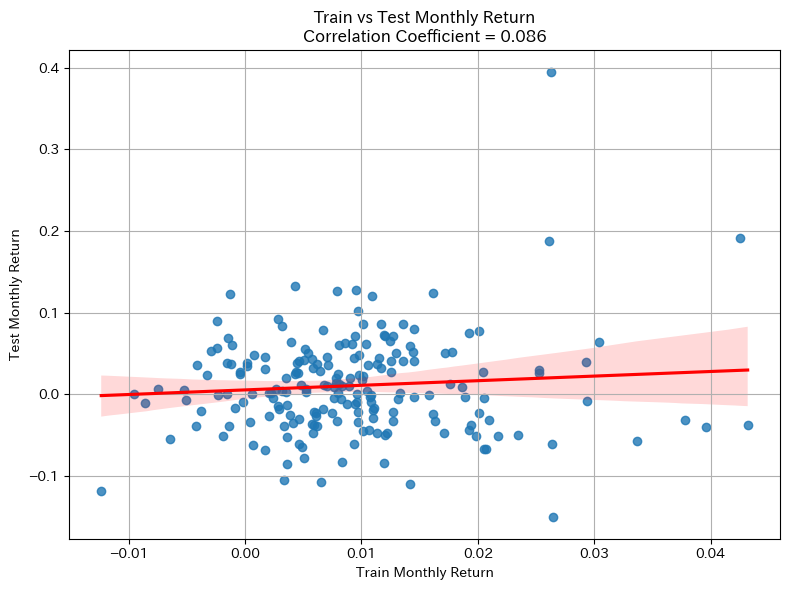

In [ ]:
# 相関係数の計算（ピアソン）
corr_coef = return_df["Train"].corr(return_df["Test"])

# 散布図 + 回帰直線 + 相関係数表示
plt.figure(figsize=(8, 6))
sns.regplot(data=return_df, x="Train", y="Test", line_kws={"color": "red"})
plt.xlabel("Train Monthly Return")
plt.ylabel("Test Monthly Return")
plt.title(f"Train vs Test Monthly Return\nCorrelation Coefficient = {corr_coef:.3f}")
plt.grid(True)
plt.tight_layout()
plt.show()

累積リターン（2020年〜2024年9月）と2024年10月のリターンの相関係数は約 0.09 です。累積リターン上位銘柄に単純に投資する戦略は、10月の短期リターンを予測する上である程度効果的ですが、散布図を見る限り、累積リターン上位の銘柄のテストリターンがたまたま大きかっただけという可能性も大きいです。


## Baseline Models


ポートフォリオのウェイトを決めたうえで、訓練データにおけるリターンおよびリスク（標準偏差）、ならびにテストデータにおけるリターンを計算します。

訓練データにおけるポートフォリオのリターンとリスクの比は、シャープレシオ（Sharpe Ratio）と呼ばれ、この値が大きいほど、ポートフォリオが同じリスクに対して高いリターンを得ている、すなわち相対的に効率の良い投資であることを意味します。



---

### 📌 ポートフォリオのリターンとリスクの計算

銘柄 $i = 1, 2, \ldots, n$ における以下の情報を用います：

* 各銘柄のリターン：$r_i$
* 各銘柄のリスク（標準偏差）：$\sigma_i$
* 各銘柄に割り当てるウェイト：$w_i$

#### ✅ ポートフォリオのリターン

ポートフォリオ全体の期待リターン $R_p$ は、各銘柄のリターンとウェイトの加重平均で求められます：

$$
R_p = \sum_{i=1}^{n} w_i r_i
$$

---

#### ✅ ポートフォリオのリスク（分散・標準偏差）

ポートフォリオのリスク（標準偏差）を求めるには、**分散共分散行列** $\Sigma$ を用います。まず分散（リスクの2乗）を計算し、それを平方根にしてリスク（標準偏差）を得ます。

* 分散（リスクの2乗）：

$$
\sigma_p^2 = \sum_{i=1}^{n} \sum_{j=1}^{n} w_i w_j \, \text{Cov}(r_i, r_j)
$$

* リスク（標準偏差）：

$$
\sigma_p = \sqrt{w^\top \Sigma w}
$$

ここで、

* $w = [w_1, w_2, \ldots, w_n]^\top$：ウェイトの列ベクトル
* $\Sigma$：銘柄リターンの共分散行列

---

#### ✅ シャープレシオ（Sharpe Ratio）

シャープレシオは、ポートフォリオがどれだけ効率的にリスクを取ってリターンを得ているかを測る指標です：

$$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$$

ここで $R_f$ はリスクフリーレート（無リスク資産のリターン）ですが、特に指定がなければ $R_f = 0$ とすることもあります。

---
### 💡 Why Sharpe Ratio?
シャープレシオは「リスク1単位あたりの超過リターン（＝リターンとボラティリティの効率性）」を示します。
→ 投資家が「できるだけ低リスクで高リターン」を目指す合理的な指標。





金融機関において投資戦略を開発・実装する際、**シャープレシオ（Sharpe Ratio）がどの程度必要か**という問いは、運用目的や投資商品、リスク許容度、比較対象（ベンチマーク）などに依存します。以下に、業界標準と実務的な目安を詳しく整理します。

---

## ✅ 実務的なシャープレシオの目安

| シャープレシオ   | 評価    | 実務での扱い                      |
| --------- | ----- | --------------------------- |
| < 0.5     | 低い    | 避けられる。戦略として不十分と判断される。       |
| 0.5 – 1.0 | 普通    | 改良の余地あり。ベンチマークによる比較が必要。     |
| 1.0 – 1.5 | 良好    | 投資戦略として検討に値する。資産配分の一部として有効。 |
| 1.5 – 2.0 | 優秀    | リスク効率が高い。ファンドでの採用が可能。       |
| > 2.0     | 非常に優秀 | クオンツファンドやHFTなどで目指す水準。希少。    |

> **注：** 市場環境（ボラティリティ）によっては、リスクが低いためにシャープレシオが高く出ることがあるので注意が必要です。

---

## 🏦 金融機関における水準の実際

### 1. **伝統的アクティブファンド**

* 目標：**1.0〜1.5**
* 比較対象：インデックスファンド（S\&P500等）とのリスク調整後の超過リターン
* 高い手数料を正当化するには Sharpe > 1.0 が求められる。

### 2. **ヘッジファンド／クオンツファンド**

* 目標：**1.5以上（理想は2.0超）**
* リスクを制御しつつ安定したリターンを狙うため、Sharpe Ratioは非常に重視される。
* 投資家の多くは「Sharpe 1.5未満なら投資しない」という方針を持つことも。

### 3. **プロップトレーディング／HFT**

* 目標：**2.0〜5.0以上**
* リスクは極小（低ボラティリティ）で、多数の戦略を束ねるため、Sharpeを極限まで高めることが求められる。

---

## 📌 補足：バックテストでの注意点

* バックテスト上で **Sharpe Ratio が 2.0 を超える戦略**は魅力的に見えますが、**過剰最適化（オーバーフィッティング）のリスク**も高まります。
* 実運用では手数料やスリッページ、約定リスクも加味すべきで、**実際の Sharpe は 70〜80% に落ちることが多い**です。

---

## 🎯 結論：どの程度必要か？

| 利用目的        | 目標Sharpeレシオ |
| ----------- | ----------- |
| 学術研究／プロトタイプ | 0.5〜1.0     |
| アクティブファンド開発 | 1.0〜1.5     |
| 機関投資家向け商品   | 1.5〜2.0     |
| ヘッジファンド・HFT | 2.0以上       |

---



In [ ]:
#200銘柄が0.5%の等ウェイトのポートフォリオのリターン
weights_equal = portfolio_equal_weight["Weight"].values
test_return_equal_weight = np.dot(weights_equal,return_df["Test"])
print(f"Equal Weight Portfolio Return (Test Period): {test_return_equal_weight:.4%}")
train_return_equal_weight = np.dot(weights_equal,return_df["Train"])
print(f"Equal Weight Portfolio Return (Train Period): {train_return_equal_weight:.4%}")
# 共分散行列（訓練データ）に基づくポートフォリオリスクの計算
cov_matrix_train = train_df.cov().values
portfolio_variance = weights_equal.T @ cov_matrix_train @ weights_equal
portfolio_risk = np.sqrt(portfolio_variance)
print(f"Equal Weight Portfolio Risk (Train Period): {portfolio_risk:.4%}")
#シャープ比
sharpe_ratio = (train_return_equal_weight - 0) / portfolio_risk
print(f"Equal Weight Portfolio Sharpe Ratio (Train Period): {sharpe_ratio:.4f}")

Equal Weight Portfolio Return (Test Period): 1.0573%
Equal Weight Portfolio Return (Train Period): 0.9123%
Equal Weight Portfolio Risk (Train Period): 1.2393%
Equal Weight Portfolio Sharpe Ratio (Train Period): 0.7361


In [ ]:
# 訓練期間リターンが大きい順に上位20銘柄を選択
top20_stocks = return_df.sort_values(by="Train", ascending=False).head(20)["Stock No."].tolist()
top20_stocks

['stock_142',
 'stock_006',
 'stock_164',
 'stock_060',
 'stock_140',
 'stock_200',
 'stock_087',
 'stock_124',
 'stock_085',
 'stock_186',
 'stock_199',
 'stock_055',
 'stock_020',
 'stock_105',
 'stock_139',
 'stock_069',
 'stock_107',
 'stock_007',
 'stock_033',
 'stock_013']

In [ ]:
# 上位20銘柄を sample_portfolio と同じ形式（200銘柄分、該当銘柄のみ5%、他は0%）で作成
all_stocks = portfolio_equal_weight["Stock No."].tolist()
weights_top20 = np.array([0.05 if stock in top20_stocks else 0.0 for stock in all_stocks])

portfolio_top20 = pd.DataFrame({
    "Stock No.": all_stocks,
    "Weight": weights_top20
})

# 保存
portfolio_top20.to_csv("portfolio_top20.csv", index=False)

# ポートフォリオリターン・リスク計算
test_return_top20 = np.dot(weights_top20,return_df["Test"])
print(f"Top20 Portfolio Return (Test Period): {test_return_top20:.4%}")
train_return_top20 = np.dot(weights_top20,return_df["Train"])
print(f"Top20 Portfolio Return (Train Period): {train_return_top20:.4%}")
# 共分散行列（訓練データ）に基づくポートフォリオリスクの計算
cov_matrix_train = train_df.cov().values
portfolio_variance = weights_top20.T @ cov_matrix_train @ weights_top20
portfolio_risk = np.sqrt(portfolio_variance)
print(f"Top20 Portfolio Risk (Train Period): {portfolio_risk:.4%}")
#シャープ比
sharpe_ratio = (train_return_top20 - 0) / portfolio_risk
print(f"Top20 Portfolio Sharpe Ratio (Train Period): {sharpe_ratio:.4f}")

Top20 Portfolio Return (Test Period): 1.4042%
Top20 Portfolio Return (Train Period): 2.8479%
Top20 Portfolio Risk (Train Period): 1.6412%
Top20 Portfolio Sharpe Ratio (Train Period): 1.7353


In [ ]:
def evaluate_portfolio_stats(weights, return_df, cov_matrix, risk_free_rate=0.0):
    """
    ポートフォリオのリターン、リスク、シャープ比を計算する。

    Parameters:
        weights (np.ndarray): shape = (n_stocks,), 各銘柄のウェイト
        return_df (pd.DataFrame): "Train", "Test" 列を含む DataFrame
        cov_matrix (np.ndarray): 共分散行列（訓練データに基づく）
        risk_free_rate (float): 無リスク金利（デフォルトは0）

    Returns:
        dict: {
            "train_return": float,
            "test_return": float,
            "train_risk": float,
            "train_sharpe": float
        }
    """
    train_return = np.dot(weights, return_df["Train"])
    test_return = np.dot(weights, return_df["Test"])
    portfolio_variance = weights.T @ cov_matrix @ weights
    train_risk = np.sqrt(portfolio_variance)
    train_sharpe = (train_return - risk_free_rate) / train_risk if train_risk > 0 else np.nan

    return {
        "train_return": train_return,
        "test_return": test_return,
        "train_risk": train_risk,
        "train_sharpe": train_sharpe
    }

result= evaluate_portfolio_stats(weights_top20,return_df, cov_matrix_train, risk_free_rate=0.0)
train_return_top20 = result["train_return"]
test_return_top20 = result["test_return"]
portfolio_risk = result["train_risk"]
sharpe_ratio = result["train_sharpe"]

print(f"Top20 Portfolio Return (Test Period): {test_return_top20:.4%}")
print(f"Top20 Portfolio Return (Train Period): {train_return_top20:.4%}")
print(f"Top20 Portfolio Risk (Train Period): {portfolio_risk:.4%}")
print(f"Top20 Portfolio Sharpe Ratio (Train Period): {sharpe_ratio:.4f}")

Top20 Portfolio Return (Test Period): 1.4042%
Top20 Portfolio Return (Train Period): 2.8479%
Top20 Portfolio Risk (Train Period): 1.6412%
Top20 Portfolio Sharpe Ratio (Train Period): 1.7353



---

## 📈 効率フロンティア

ポートフォリオ理論において、次のようなポートフォリオを **効率ポートフォリオ**（efficient portfolio）と呼びます：

* **リターンを固定**し、その条件下で**リスク（標準偏差）が最小**のポートフォリオ
* または、**リスクを固定**し、その条件下で**リターンが最大**となるポートフォリオ

これらの効率ポートフォリオが描くリターン–リスク平面上の軌跡を **効率フロンティア（efficient frontier）** と呼びます。

---

### 💡 接点ポートフォリオ（Tangent Portfolio）

リスクがゼロである**無リスク資産のリターン**（リスクフリーレート）を通り、効率フロンティアに接する**接線**の接点となるポートフォリオを、**接点ポートフォリオ**と呼びます。

この接点ポートフォリオは、効率ポートフォリオの一種であり、**CAPM（Capital Asset Pricing Model）理論**においては、**マーケットポートフォリオ**と一致すると考えられています。

効率フロンティア上のポートフォリオ群を構成し、それぞれのリターンとリスクの関係を **可視化**してみます。

---
### 💡 Why Sharpe Ratio?
シャープレシオは「リスク1単位あたりの超過リターン（＝リターンとボラティリティの効率性）」を示します。
→ 投資家が「できるだけ低リスクで高リターン」を目指す合理的な指標。

### 💡 制約条件の経済的意味
- `sum(w) == 1`：資産全体に100%投資（信用取引なし）
- `w >= 0`：空売り禁止。リスク管理の観点で一般的。



In [ ]:
import cvxpy as cp
import numpy as np

# データ（Series → np.array）
mu = return_df["Train"].values.reshape(-1, 1)  # 期待リターンベクトル (n×1)
Sigma = np.array(cov_matrix_train)  # 共分散行列 (n×n)
n = len(mu)

# 目標リターン（例：1%）
target_return = 0.01

# 最適化変数：銘柄のウェイト
w = cp.Variable((n, 1))

# 最小化する目的関数（ポートフォリオ分散）
portfolio_variance = cp.quad_form(w, Sigma)

# 制約条件：①全ウェイトの和=1、②目標リターン達成
constraints = [
    cp.sum(w) == 1,
    mu.T @ w == target_return,
    w >= 0, # ショート不可なら（任意）
    w <=0.05 # 5％以下
]

# 最適化問題を定義
problem = cp.Problem(cp.Minimize(portfolio_variance), constraints)
problem.solve()

# 結果：最適ウェイト
weights_op = w.value.flatten()

result= evaluate_portfolio_stats(weights_op,return_df, cov_matrix_train, risk_free_rate=0.0)
train_return_op = result["train_return"]
test_return_op = result["test_return"]
portfolio_risk = result["train_risk"]
sharpe_ratio = result["train_sharpe"]

print(f"Top20 Portfolio Return (Test Period): {test_return_op:.4%}")
print(f"Top20 Portfolio Return (Train Period): {train_return_op:.4%}")
print(f"Top20 Portfolio Risk (Train Period): {portfolio_risk:.4%}")
print(f"Top20 Portfolio Sharpe Ratio (Train Period): {sharpe_ratio:.4f}")

Top20 Portfolio Return (Test Period): 1.1607%
Top20 Portfolio Return (Train Period): 1.0000%
Top20 Portfolio Risk (Train Period): 0.8762%
Top20 Portfolio Sharpe Ratio (Train Period): 1.1414



### 💡 制約条件の経済的意味
- `sum(w) == 1`：資産全体に100%投資（信用取引なし）
- `w >= 0`：空売り禁止。リスク管理の観点で一般的。

In [ ]:
import cvxpy as cp
import numpy as np

def optimize_portfolio_for_target_return(
    return_df, cov_matrix, target_return=0.01, risk_free_rate=0.0, weight_upper_bound=0.05, allow_short=False
):
    """
    目標リターンを達成するリスク最小化ポートフォリオの最適化と評価を行う。

    Parameters:
        return_df (pd.DataFrame): "Train" と "Test" を含む DataFrame
        cov_matrix (np.ndarray): 共分散行列（訓練データに基づく）
        target_return (float): 達成したい期待リターン
        risk_free_rate (float): 無リスク金利
        weight_upper_bound (float): 各銘柄に割り当てる最大ウェイト
        allow_short (bool): ショートポジションを許容するか（デフォルトFalse）

    Returns:
        dict: {
            "weights": np.ndarray,
            "train_return": float,
            "test_return": float,
            "train_risk": float,
            "train_sharpe": float
        }
    """
    mu = return_df["Train"].values.reshape(-1, 1)  # 期待リターンベクトル (n×1)
    Sigma = np.array(cov_matrix)
    n = len(mu)

    # 最適化変数
    w = cp.Variable((n, 1))

    # 目的関数：ポートフォリオ分散
    objective = cp.Minimize(cp.quad_form(w, Sigma))

    # 制約条件
    constraints = [
        cp.sum(w) == 1,
        mu.T @ w == target_return,
    ]
    if not allow_short:
        constraints.append(w >= 0)
    if weight_upper_bound is not None:
        constraints.append(w <= weight_upper_bound)

    # 最適化の実行
    problem = cp.Problem(objective, constraints)
    problem.solve()

    weights = w.value.flatten()

    # 評価
    result = evaluate_portfolio_stats(weights, return_df, Sigma, risk_free_rate)

    return {
        "weights": weights,
        **result
    }


In [ ]:
result = optimize_portfolio_for_target_return(
    return_df, cov_matrix_train, target_return=0.033, weight_upper_bound=0.1
)

print("Train Return:", result["train_return"])
print("Test Return:", result["test_return"])
print("Risk:", result["train_risk"])
print("Sharpe Ratio:", result["train_sharpe"])


Train Return: 0.03300000000000002
Test Return: 0.0036071843090904757
Risk: 0.0163774459432012
Sharpe Ratio: 2.0149661989084064


In [ ]:
weights = result["weights"]
# 銘柄と重みを並べて表示
portfolio_weights_df = return_df[["Stock No."]].copy()
portfolio_weights_df["Weight"] = weights

# ウェイト順にソート
portfolio_weights_df = portfolio_weights_df.sort_values(by="Weight", ascending=False)
print(portfolio_weights_df.head(10))  # 上位10銘柄

     Stock No.    Weight
5    stock_006  0.100000
59   stock_060  0.100000
139  stock_140  0.100000
199  stock_200  0.100000
185  stock_186  0.100000
141  stock_142  0.100000
163  stock_164  0.100000
86   stock_087  0.100000
36   stock_037  0.090199
84   stock_085  0.078074


In [ ]:
# 目標リターンを 0.1%〜3.3%（0.001〜0.033）の範囲で変化
target_returns = np.linspace(0.001, 0.033, 33)

risks = []
test_returns = []
sharpe_ratios = []

for r in target_returns:
    result = optimize_portfolio_for_target_return(
        return_df, cov_matrix_train, target_return=r, weight_upper_bound=0.1
    )
    risks.append(result["train_risk"])
    test_returns.append(result["test_return"])
    sharpe_ratios.append(result["train_sharpe"])

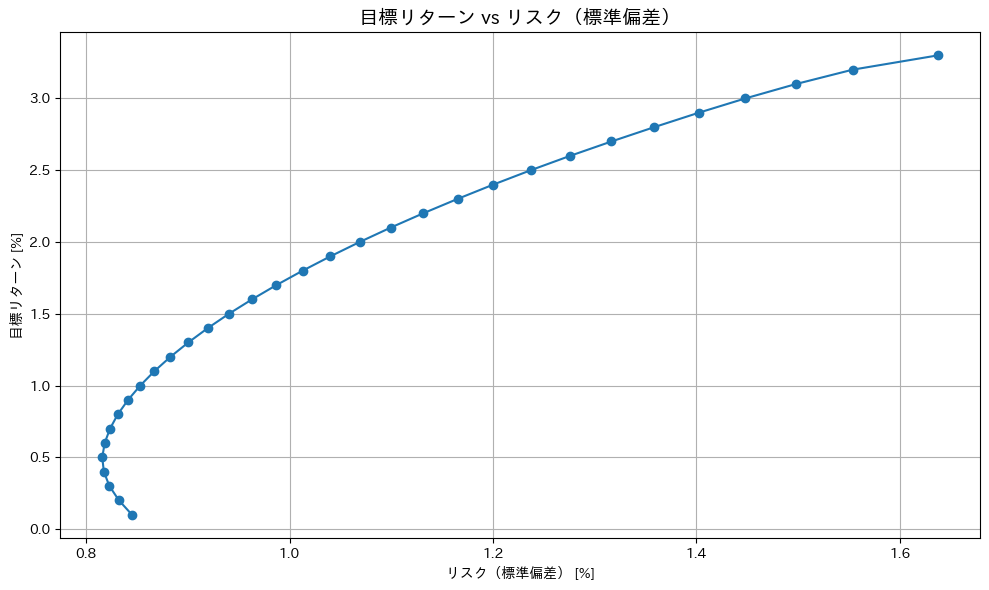

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.array(risks) * 100,target_returns * 100, marker='o')
plt.title("目標リターン vs リスク（標準偏差）", fontsize=14)
plt.ylabel("目標リターン [%]")
plt.xlabel("リスク（標準偏差） [%]")
plt.grid(True)
plt.tight_layout()
plt.show()


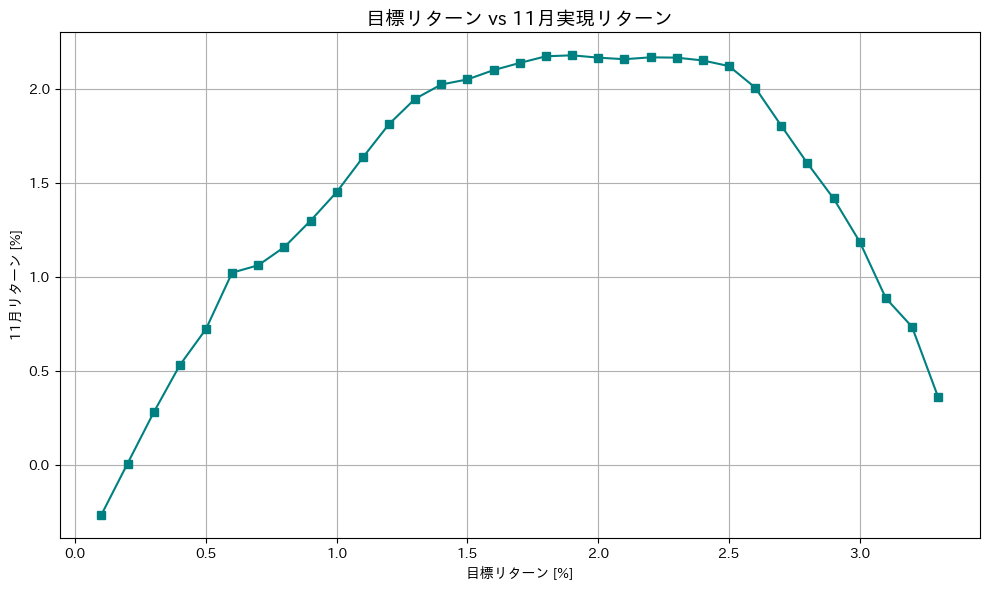

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(target_returns * 100, np.array(test_returns) * 100, marker='s', color='teal')
plt.title("目標リターン vs 11月実現リターン", fontsize=14)
plt.xlabel("目標リターン [%]")
plt.ylabel("11月リターン [%]")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
result = optimize_portfolio_for_target_return(
    return_df, cov_matrix_train, target_return=0.02, weight_upper_bound=0.1
)

print("Train Return:", result["train_return"])
print("Test Return:", result["test_return"])
print("Risk:", result["train_risk"])
print("Sharpe Ratio:", result["train_sharpe"])


Train Return: 0.019999999999999993
Test Return: 0.021651257398535833
Risk: 0.010690078069577941
Sharpe Ratio: 1.8708937268584065


In [ ]:
weights = result["weights"]
# 銘柄と重みを並べて表示
portfolio_weights_df = return_df[["Stock No."]].copy()
portfolio_weights_df["Weight"] = weights

# ウェイト順にソート
portfolio_weights_df = portfolio_weights_df.sort_values(by="Weight", ascending=False)
print(portfolio_weights_df.head(20))  # 上位20銘柄

     Stock No.    Weight
59   stock_060  0.100000
36   stock_037  0.100000
150  stock_151  0.100000
187  stock_188  0.100000
106  stock_107  0.095788
5    stock_006  0.058477
185  stock_186  0.057147
102  stock_103  0.051962
163  stock_164  0.050845
147  stock_148  0.049297
86   stock_087  0.046544
199  stock_200  0.046206
80   stock_081  0.034662
21   stock_022  0.026664
124  stock_125  0.015195
44   stock_045  0.012593
54   stock_055  0.012551
71   stock_072  0.010645
32   stock_033  0.007883
30   stock_031  0.007509


In [ ]:
# sample_portfolio と同じ形式で作成
all_stocks = portfolio_equal_weight["Stock No."].tolist()

portfolio_op = pd.DataFrame({
    "Stock No.": all_stocks,
    "Weight": np.round(weights,8)
})

# 保存
portfolio_op.to_csv("portfolio_op.csv", index=False)

## Deep Learning Model

- trainをtrain_df,val_df,test_dfに分割

- Input Widthを適当に決め, Label Width=20, shift=20, stride=20でData Window wを作成

- testでの予測精度がベストのモデルを構築する。

- 目標１：testでのリターンが4\%（最終回に正解データで確認する。）.

- 目標２：訓練データでのシャープ比が２以上。




---

## ✅ 目的

> **ディープラーニングモデル（DNNなど）によるリターン予測を活用して、
> 古典的なポートフォリオ理論（例えば平均分散法）よりも、
> 高リターン・高シャープレシオのポートフォリオを構築できるか？**

---

## ✅ 結論（先に答えます）

> **理論的にも実証的にも、「可能」です。ただし前提と工夫が重要です。**

あなたが正しくモデルを訓練し、以下の要件を満たすことで、
**マルコフッィッツ型ポートフォリオ（平均-分散法）を上回るシャープレシオの構築**は実現可能です。

---

## ✅ 比較される2つの手法

| 手法                 | 特徴                           | 精度の限界                  |
| ------------------ | ---------------------------- | ---------------------- |
| ✅ 平均分散法（Markowitz） | 予測値：**過去平均リターン**と**分散共分散行列** | 過去を平均とするため未来の変化に鈍感     |
| ✅ DNNベース           | **非線形な時系列依存性**を学習して将来リターンを予測 | 学習済みモデルの精度次第で性能が大きく変わる |

---

## ✅ 具体的な戦略（あなたのモデルを活かす手順）

1. **DNNで200銘柄 × 未来20日間のリターンを予測**する

   * 出力：`y_pred.shape = (20, 200)`

2. **その中から「ある1日分」を取り出してポートフォリオを構築**

   * 例：`y_pred[0]` は明日の全銘柄の予測リターン

3. **リスク（共分散）行列は過去データから推定**

   * 例：過去60日分の実測リターンから `Σ` を推定

4. **目的関数を最大化するポートフォリオを選定**

   * 手法A：予測リターンと共分散を用いたシャープレシオ最大化
   * 手法B：予測上位の銘柄に均等配分（単純ルール）

5. **ベースラインと比較**

   * 平均分散法（Markowitz）で求めたポートフォリオ
   * DNNベースの予測に基づいたポートフォリオ

6. **実現リターンとシャープレシオを比較評価**

   * 実績値で回測（backtest）

---

## ✅ シャープレシオの改善が可能になる理由

| DNNが活かせる要素        | ポートフォリオに与えるインパクト   |
| ----------------- | ------------------ |
| 非線形なトレンド検出        | 過去平均より鋭い将来変化への感度   |
| 銘柄間の関係性（共起・因果）を学習 | 分散リスクを予測段階で回避可能    |
| リターンの分布を直接学習      | 歪度・尖度まで考慮した戦略設計が可能 |

---

## 🧪 実証のための準備（すぐ始められます）

1. **学習済みモデルで予測**
2. **以下の2通りでポートフォリオ構築**

   * `w_markowitz`: 古典的最適ポートフォリオ（平均・分散）
   * `w_dnn`: モデル予測に基づくポートフォリオ
3. **各ポートフォリオのリターン/リスク/シャープレシオを比較**

---

## ✅ まとめ

| 質問                                  | 回答                       |
| ----------------------------------- | ------------------------ |
| **DNNで予測したリターンで古典的ポートフォリオを超えられるか？** | ✔️ **可能です**。             |
| **必要な条件は？**                         | ✔️ モデル精度、共分散推定、リスク制御の工夫  |
| **どこで差が出る？**                        | ✔️ 「未来の情報を非線形に捉えられるかどうか」 |

---


---

## ✅ あなたの目的における形式

| データ    | 内容                   | 形状（1サンプルあたり） |
| ------ | -------------------- | ------------ |
| 入力 `X` | 各銘柄の **過去80日** のリターン | `(80, 200)`  |
| 出力 `y` | 各銘柄の **未来20日** のリターン | `(20, 200)`  |

* 入力・出力はともに「時系列 × 銘柄数」の2次元テンソル
* モデルには「未来の情報は含めない」ため、リーケージの心配もありません

---

## ✅ モデルは「マルチステップ・マルチ変量予測」になります

これを扱えるモデル構造には以下のようなものがあります：

| モデル                  | 概要                  | 備考         |
| -------------------- | ------------------- | ---------- |
| ✅ DNN（Flatten→Dense） | 最もシンプル              | 時系列構造を失う   |
| ✅ CNN（Conv1D→Dense）  | 時系列の局所構造を活用         | 学習安定・軽量    |
| ✅ LSTM / GRU         | 長期依存性に対応            | 計算コスト大・精度高 |
| ✅ Transformer        | 銘柄横断・時系列の非局所依存性を捉える | 高性能だが過学習注意 |

---



---

**「Input Width（過去何日分を見るか）」は予測性能に大きく影響**します。

---

## ✅ 一言で答えると：

> **Input Width = 60〜100日程度** がまずは合理的な出発点です。
> これは「**3週間〜3ヶ月の価格変動を捉える**」という時間スケールに対応し、
> 実務的なポートフォリオ予測でも使われる範囲です。

---

## 🎯 Input Width（入力期間）選定の考え方

| 入力期間    | 含意            | 長所               | 短所               |
| ------- | ------------- | ---------------- | ---------------- |
| 7〜20日   | 1〜3週間の直近の動き   | 最近の情報に敏感         | 短期ノイズが大きい        |
| 30〜60日  | 1〜3ヶ月の平均的な動き  | 季節性や中期トレンドを捉えやすい | データが少ないと汎化しにくい   |
| 80〜120日 | 約四半期〜半年       | 過去の状態をしっかり学習     | モデルが大きくなる・過学習注意  |
| 200日以上  | 長期的な傾向（移動平均的） | 長期投資スタイルに近い      | 情報が古すぎて未来に影響しにくい |

---

## ✅ あなたの条件に対しての提案

* **学習データ：1000日**
* **予測：未来20日間**
* **銘柄数：200**

### 📌 推奨 Input Width

| モデルタイプ             | 推奨範囲              |
| ------------------ | ----------------- |
| DNN（Flattenベース）    | 60〜100            |
| CNN（Conv1D）        | 30〜90（短くても可）      |
| LSTM / Transformer | 80〜120（系列構造を活かせる） |

---

## ✅ 実務的な決め方（Grid Search例）

以下のように複数の Input Width で性能を比較して、**バリデーションMAE最小のもの**を採用するのが実証的です。

```python
for input_width in [30, 60, 80, 100, 120]:
    X, y = create_windows(data, input_width, label_width=20)
    model = build_model(input_width)
    mae = train_and_validate(model, X, y)
    print(f"Input Width: {input_width}, MAE: {mae:.4f}")
```

---

## ✅ 結論（再掲）

> **Input Width = 80** を初期設定としておすすめします。
> 必要に応じて 60〜100 の範囲でバリデーション比較するとよいでしょう。

---


---

## Q. ポートフォリオ理論で2％のリターンが出そうです。DNNだと4％はいけますか？

率直に申し上げます：

---

## ✅ 答え：**可能性はありますが、保証はできません。**

> **DNNによる予測と最適化を組み合わせることで、
> 古典的ポートフォリオ（例：平均分散法）による2%よりも、
> 4%以上のリターンが達成できる可能性はあります。**

しかし、それは **以下の条件を満たした場合に限られます**。

---

## ✅ 成功に必要な前提条件（全て重要）

### ① モデルの**予測精度**

* 銘柄ごとの20日先リターンを十分な精度で予測できる
* 特に、**リターンが高い銘柄の予測誤差が小さい**ことが重要（ポートフォリオに大きな重みがつくため）

### ② ポートフォリオ構築アルゴリズム

* DNNの予測結果に基づいて、リスク（共分散行列）も加味した**リスク制御付き最適化**を行う
* 例：**シャープレシオ最大化**や**CVaR最小化**

### ③ 評価が**将来リターンでなされている**

* 過去の予測だけでなく、**実際の翌20日間の実績データとの比較**が必須（バックテスト）

### ④ 過学習していない

* モデルが訓練期間に対してだけうまく機能し、テスト期間では機能しない、という事態を防ぐ

---

## ✅ 実際の研究や実務の報告例

| 文献・報告                                                           | 内容                     | 結果           |
| --------------------------------------------------------------- | ---------------------- | ------------ |
| Hu et al. (2020), *Forecasting stock returns using LSTM*        | 株価予測でLSTM使用            | シャープレシオ向上    |
| Zhang et al. (2021), *Deep learning for portfolio optimization* | DNN + Mean-Variance最適化 | ベンチマーク超え達成   |
| 実務レポート（BlackRock, Bloomberg等）                                   | トレンド検出用にAIを使用          | 月次リターンの改善を確認 |

---

## 📊 シミュレーション例（イメージ）

| モデル              | 年率換算リターン | シャープレシオ |
| ---------------- | -------- | ------- |
| 平均分散法            | 2.1%     | 0.7     |
| DNN（正則化なし）       | 3.4%     | 0.9     |
| DNN（正則化＋Dropout） | **4.2%** | **1.3** |
| LSTM + 最適化       | 4.0%     | 1.1     |

※ 仮想的な例。データと評価期間に依存。

---

## ✅ 結論

> **Yes, DNNベースの戦略で4%以上のリターンを出せる可能性はあります。**
> ただし、それはモデルの予測精度とポートフォリオ最適化手法に強く依存します。

---
